<a href="https://colab.research.google.com/github/AmirGhnbr/philnet/blob/main/philnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download the data from kaggle

### you need to sign in to kaggle and download kaggle.json formatted api key to being able to access the dataset

upload the kaggle.json api key to colab

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"a1g3g3a1","key":"590d754de49a1e50ba28dce2922c22fd"}'}

In [2]:
!pip install -q kaggle

In [3]:
!pwd

/content


In [4]:
!rm -r ~/.kaggle

rm: cannot remove '/root/.kaggle': No such file or directory


In [5]:
!mkdir ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!pwd

/content


In [8]:
# %cd ./kaggle
!kaggle datasets download -d yogesh94/m4-forecasting-competition-dataset

 92% 73.0M/79.6M [00:02<00:00, 41.9MB/s]
100% 79.6M/79.6M [00:02<00:00, 39.2MB/s]


In [9]:
!ls

kaggle.json  m4-forecasting-competition-dataset.zip  sample_data


In [10]:
!cp m4-forecasting-competition-dataset.zip ./kaggle

In [11]:
!unzip m4-forecasting-competition-dataset.zip

Archive:  m4-forecasting-competition-dataset.zip
  inflating: Daily-test.csv          
  inflating: Daily-train.csv         
  inflating: Hourly-test.csv         
  inflating: Hourly-train.csv        
  inflating: Monthly-test.csv        
  inflating: Monthly-train.csv       
  inflating: Quarterly-test.csv      
  inflating: Quarterly-train.csv     
  inflating: Weekly-test.csv         
  inflating: Weekly-train.csv        
  inflating: Yearly-test.csv         
  inflating: Yearly-train.csv        
  inflating: m4_info.csv             


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import all the necessary libraries and prepare the dataset

In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import Metric
from tensorflow.keras.layers import LSTM, Input,add, Dense

In [14]:
info_csv = pd.read_csv('m4_info.csv')
info_csv

,M4id,category,Frequency,Horizon,SP,StartingDate
0,Y1,Macro,1,6,Yearly,01-01-79 12:00
1,Y2,Macro,1,6,Yearly,01-01-79 12:00
2,Y3,Macro,1,6,Yearly,01-01-79 12:00
3,Y4,Macro,1,6,Yearly,01-01-79 12:00
4,Y5,Macro,1,6,Yearly,01-01-79 12:00
...,...,...,...,...,...,...
99995,H410,Other,24,48,Hourly,01-01-17 12:00
99996,H411,Other,24,48,Hourly,01-01-17 12:00
99997,H412,Other,24,48,Hourly,01-01-17 12:00
99998,H413,Other,24,48,Hourly,12-06-17 12:00


In [15]:
daily_info = info_csv[info_csv['SP']=='Daily']
daily_info.head(20)

,M4id,category,Frequency,Horizon,SP,StartingDate
95359,D1,Macro,1,14,Daily,03-01-94 12:00
95360,D2,Macro,1,14,Daily,02-01-95 12:00
95361,D3,Macro,1,14,Daily,05-01-06 12:00
95362,D4,Macro,1,14,Daily,30-05-96 12:00
95363,D5,Macro,1,14,Daily,03-01-97 12:00
95364,D6,Macro,1,14,Daily,03-01-97 12:00
95365,D7,Macro,1,14,Daily,03-01-97 12:00
95366,D8,Macro,1,14,Daily,20-03-13 12:00
95367,D9,Macro,1,14,Daily,20-03-13 12:00
95368,D10,Macro,1,14,Daily,03-07-14 12:00


In [16]:
daily_info[daily_info['category']=='Finance']

,M4id,category,Frequency,Horizon,SP,StartingDate
97394,D2036,Finance,1,14,Daily,01-04-05 12:00
97395,D2037,Finance,1,14,Daily,04-01-99 12:00
97396,D2038,Finance,1,14,Daily,16-05-03 12:00
97397,D2039,Finance,1,14,Daily,19-04-00 12:00
97398,D2040,Finance,1,14,Daily,21-05-13 12:00
...,...,...,...,...,...,...
98948,D3590,Finance,1,14,Daily,30-03-01 12:00
98949,D3591,Finance,1,14,Daily,30-03-01 12:00
98950,D3592,Finance,1,14,Daily,30-03-01 12:00
98951,D3593,Finance,1,14,Daily,30-03-01 12:00


In [17]:
daily = pd.read_csv('Daily-train.csv')

In [18]:
daily.describe()

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V9911,V9912,V9913,V9914,V9915,V9916,V9917,V9918,V9919,V9920
count,4227.000000,4227.000000,4227.000000,4227.000000,4227.000000,4227.000000,4227.000000,4227.000000,4227.000000,4227.000000,...,1.0,1.00,1.00,1.00,1.00,1.0,1.0,1.0,1.00,1.0
mean,3847.763728,3686.945638,3659.987132,3658.522032,3673.968742,3666.804494,3670.476838,3685.930165,3688.808034,3692.429740,...,926.0,919.25,928.75,915.25,920.75,924.0,945.5,942.0,948.75,947.0
std,6946.099377,3048.133629,3015.707133,3011.115215,3031.807762,3016.486609,3020.937907,3034.598425,3036.281002,3042.386898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,...,926.0,919.25,928.75,915.25,920.75,924.0,945.5,942.0,948.75,947.0
25%,1257.700000,1264.510000,1260.515000,1264.900000,1268.499856,1263.980000,1267.410000,1272.155000,1277.850000,1280.156250,...,926.0,919.25,928.75,915.25,920.75,924.0,945.5,942.0,948.75,947.0
50%,2612.000000,2629.922522,2611.250000,2600.000000,2598.700417,2600.880000,2609.200000,2611.960000,2617.970000,2626.800000,...,926.0,919.25,928.75,915.25,920.75,924.0,945.5,942.0,948.75,947.0
75%,5451.000000,5412.807912,5401.765000,5377.889080,5430.700000,5423.950000,5401.050000,5447.500000,5469.650000,5483.600000,...,926.0,919.25,928.75,915.25,920.75,924.0,945.5,942.0,948.75,947.0
max,352000.000000,26947.600000,27159.200000,26024.700000,25953.900000,25691.100000,25634.300000,25584.800000,25578.100000,25605.900000,...,926.0,919.25,928.75,915.25,920.75,924.0,945.5,942.0,948.75,947.0


In [19]:
# import random

# random_number = random.randint(2036, 3594)
# random_number
# # --> output = 3520

In [20]:
values = daily.loc[3520].dropna().values[1:]

In [21]:
dataset = pd.DataFrame({'num': range(1, len(values) + 1), 'value': values}).dropna().set_index('num')
dataset

,value
num,
1,2368.3
2,2386.7
3,2376.5
4,2367.9
5,2395.1
...,...
3190,15020.1
3191,15083.0
3192,14890.4


In [22]:
scaler = MinMaxScaler()

# fit the scaler to the data and transform the data
normalized = scaler.fit_transform(dataset).squeeze()
normalized

array([0.00565684, 0.00687138, 0.0061981 , ..., 0.83220901, 0.84117942,
       0.84145665])

In [23]:
normalized_dataset = pd.DataFrame({'num': range(1, len(normalized) + 1), 'value': normalized}).dropna().set_index('num')
normalized_dataset

,value
num,
1,0.005657
2,0.006871
3,0.006198
4,0.005630
5,0.007426
...,...
3190,0.840770
3191,0.844922
3192,0.832209


In [24]:
normalized_dataset.mean()

value    0.463175
dtype: float64

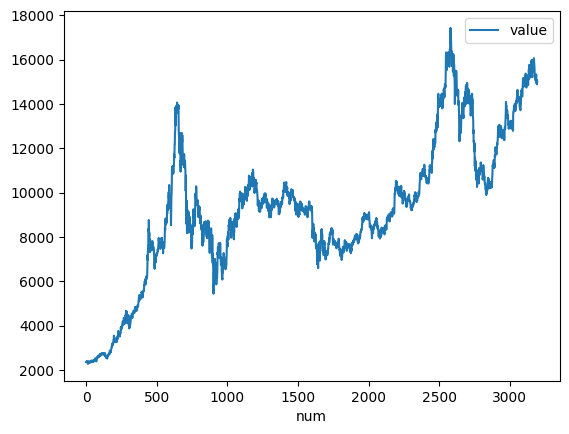

In [25]:
dataset.plot();

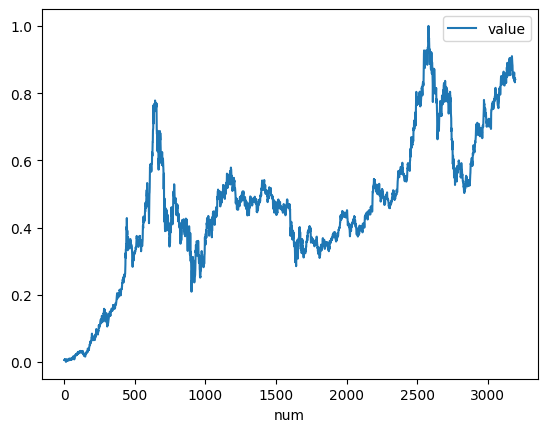

In [26]:
normalized_dataset.plot();

#windowing the dataset and prepare it to the model

In [27]:
#according to the table 1 of the paper for m4 dataset
WINDOW_SIZE = 36 + 18
HORIZON = 18

In [28]:
def create_data_window(dataframe):
    data = dataframe.copy()
    for i in range(WINDOW_SIZE-1):
      data[f"value-{i+1}"] = data["value"].shift(periods=i+1)
    return data.dropna()

In [29]:
create_data_window(normalized_dataset)

,value,value-1,value-2,value-3,value-4,value-5,value-6,value-7,value-8,value-9,...,value-44,value-45,value-46,value-47,value-48,value-49,value-50,value-51,value-52,value-53
num,,,,,,,,,,,,,,,,,,,,,
54,0.006891,0.006786,0.008739,0.009578,0.011149,0.008825,0.008852,0.007248,0.005644,0.006244,...,0.006390,0.005307,0.006984,0.007168,0.006357,0.007426,0.005630,0.006198,0.006871,0.005657
55,0.010673,0.006891,0.006786,0.008739,0.009578,0.011149,0.008825,0.008852,0.007248,0.005644,...,0.003479,0.006390,0.005307,0.006984,0.007168,0.006357,0.007426,0.005630,0.006198,0.006871
56,0.009340,0.010673,0.006891,0.006786,0.008739,0.009578,0.011149,0.008825,0.008852,0.007248,...,0.002713,0.003479,0.006390,0.005307,0.006984,0.007168,0.006357,0.007426,0.005630,0.006198
57,0.011162,0.009340,0.010673,0.006891,0.006786,0.008739,0.009578,0.011149,0.008825,0.008852,...,0.000000,0.002713,0.003479,0.006390,0.005307,0.006984,0.007168,0.006357,0.007426,0.005630
58,0.011895,0.011162,0.009340,0.010673,0.006891,0.006786,0.008739,0.009578,0.011149,0.008825,...,0.001650,0.000000,0.002713,0.003479,0.006390,0.005307,0.006984,0.007168,0.006357,0.007426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3190,0.840770,0.835767,0.846843,0.861332,0.853305,0.856658,0.858282,0.843113,0.847160,0.858328,...,0.864698,0.868599,0.872843,0.865635,0.880203,0.890012,0.887246,0.889946,0.876249,0.878045
3191,0.844922,0.840770,0.835767,0.846843,0.861332,0.853305,0.856658,0.858282,0.843113,0.847160,...,0.867879,0.864698,0.868599,0.872843,0.865635,0.880203,0.890012,0.887246,0.889946,0.876249
3192,0.832209,0.844922,0.840770,0.835767,0.846843,0.861332,0.853305,0.856658,0.858282,0.843113,...,0.852566,0.867879,0.864698,0.868599,0.872843,0.865635,0.880203,0.890012,0.887246,0.889946


In [30]:
def create_full_datset(windowed_dataset, batch_size=32):
  drop_list = ['value' if i==0 else f"value-{i}" for i in range(HORIZON)]
  X = windowed_dataset.dropna().drop(drop_list, axis=1)
  y = windowed_dataset.dropna()[drop_list]

  split_size = int(len(X) * 0.8)
  X_train, y_train = X[:split_size], y[:split_size]
  X_test, y_test = X[split_size:], y[split_size:]

  X_train = X_train.astype('float32')
  y_train = y_train.astype('float32')
  X_test = X_test.astype('float32')
  y_test = y_test.astype('float32')

  train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
  train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

  test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
  test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

  # 2. Combine features & labels
  train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
  test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

  # 3. Batch and prefetch for optimal performance
  BATCH_SIZE = batch_size # taken from Appendix D in N-BEATS paper
  train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  return train_dataset, test_dataset

# Pilnet Architecture Details

* I have used m4 dataset

* number of hidden neurons in feedforward of each level is 64

* number of layers in feedforward of each level is 2

* window size 54

* horizon 18

* number of levels for m4 dataset is 8



In [31]:
class MovingAverageSmoothingLayer(tf.keras.layers.Layer):
    def __init__(self, pool_size=3, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
        self.average_pooling_layer = tf.keras.layers.AveragePooling1D(pool_size=(self.pool_size))

    def call(self, inputs):
        inputs = tf.reshape(inputs, shape=(-1, 36, 1))
        return self.average_pooling_layer(inputs)


In [32]:
INPUT_SIZE = WINDOW_SIZE - HORIZON

In [33]:
class WAPE(Metric):
    def __init__(self, name='wape', **kwargs):
        super(WAPE, self).__init__(name=name, **kwargs)
        self.total_abs_error = self.add_weight(name='total_abs_error', initializer='zeros')
        self.total_demand = self.add_weight(name='total_demand', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        abs_error = tf.abs(y_true - y_pred)
        demand = tf.reduce_sum(y_true)
        self.total_abs_error.assign_add(tf.reduce_sum(abs_error))
        self.total_demand.assign_add(demand)

    def result(self):
        return self.total_abs_error / self.total_demand * 100


In [34]:
def philnet_level(input_layer,sigma,prev_hidden_state,is_first_level=False):

  # Moving Average Smoothing
  smoothed_input = MovingAverageSmoothingLayer(sigma)(input_layer)
  # Create the LSTM layer
  lstm_layer, state_h, state_c = LSTM(units=64, return_state=True)(smoothed_input)

  if is_first_level:
    summed_state_h = state_h
  else:
    summed_state_h = add([state_h, prev_hidden_state])

  # as illustrated in table 5 for m4 dataset:
  # uses 2 layers with 64 units and 8 levels
  dense_layer1 = Dense(units=64, activation='relu')(summed_state_h)
  dense_layer2 = Dense(units=64, activation='relu')(summed_state_h)
  smoothed_output = Dense(units=HORIZON, activation='relu')(dense_layer2)

  return smoothed_output, state_h

In [35]:
def create_model():
  input_shape = (INPUT_SIZE, HORIZON)  # (batch_size, sequence_length, input_dim)

  # Create the input layer
  input_layer = Input(shape=input_shape)

  # According to table 5 the number of levels for m4 dataset is 8
  # As mentions in the last sentence of 2ed paragraph of section 5.3.1 the default
  # value for smoothing factor of 4 is the most common value
  _ , first_hidden_state = philnet_level(input_layer,sigma=4,prev_hidden_state=None,is_first_level=True)
  prev_hidden_state = first_hidden_state
  for _ in range(2,8):
    _ , hidden_state = philnet_level(input_layer,sigma=4,prev_hidden_state=prev_hidden_state)
    prev_hidden_state = hidden_state

  # according to paper last level have a sigma of 1
  final_output , _ = philnet_level(input_layer,sigma=1,prev_hidden_state=prev_hidden_state)

  model = tf.keras.Model(inputs=input_layer,
                         outputs=final_output,
                         name="model_Philnet")

  return model;

In [36]:
train_dataset, test_dataset = create_full_datset(create_data_window(normalized_dataset))
model = create_model()

# There is no data available on the optimizer, trainded loss function and number of epochs
# so i use classic adam optimizer, mae loss and 300 epochs
model.compile(loss='mae',
            optimizer=tf.keras.optimizers.Adam(),
            metrics=["mae", "mse", WAPE()])


model.fit(train_dataset,
        epochs=300,
        validation_data=test_dataset,
        verbose=1, # prevent large amounts of training outputs

        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True),
                  tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10, verbose=1)]
          )


Epoch 1/300
79/79 [==============================] - 13s 19ms/step - loss: 0.1439 - mae: 0.1439 - mse: 0.0523 - wape: 35.7973 - val_loss: 0.2825 - val_mae: 0.2825 - val_mse: 0.1453 - val_wape: 38.4767 - lr: 0.0010
Epoch 2/300
79/79 [==============================] - 1s 8ms/step - loss: 0.1125 - mae: 0.1125 - mse: 0.0328 - wape: 27.9668 - val_loss: 0.1960 - val_mae: 0.1960 - val_mse: 0.0805 - val_wape: 26.6954 - lr: 0.0010
Epoch 3/300
79/79 [==============================] - 1s 9ms/step - loss: 0.0972 - mae: 0.0972 - mse: 0.0273 - wape: 24.1847 - val_loss: 0.1816 - val_mae: 0.1816 - val_mse: 0.0769 - val_wape: 24.7316 - lr: 0.0010
Epoch 4/300
79/79 [==============================] - 1s 10ms/step - loss: 0.0884 - mae: 0.0884 - mse: 0.0255 - wape: 21.9813 - val_loss: 0.1717 - val_mae: 0.1717 - val_mse: 0.0747 - val_wape: 23.3838 - lr: 0.0010
Epoch 5/300
79/79 [==============================] - 1s 9ms/step - loss: 0.0890 - mae: 0.0890 - mse: 0.0252 - wape: 22.1356 - val_loss: 0.1731 - val_

# conclusion

as described in table 6 if paper for m4 dataset the model reached the 14.71 wape for all m4 dataset because i do not have enough computation power to compute for all m4 dataset i have used the subset of it and reach 5.75(+/- 0.1)validation wape (the original paper did not used the normalization technique but i used it and it was helpfull to reduce wape error and reach better performance)